In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from nctpy.utils import matrix_normalization
from null_models.geomsurr import geomsurr

from brainsmash.mapgen.base import Base

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
# which_data = 'macaque'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

In [3]:
A_file = '{0}_{1}_Am.npy'.format(which_data, atlas)
A = np.load(os.path.join(indir, A_file))
print(A.shape)

(400, 400)


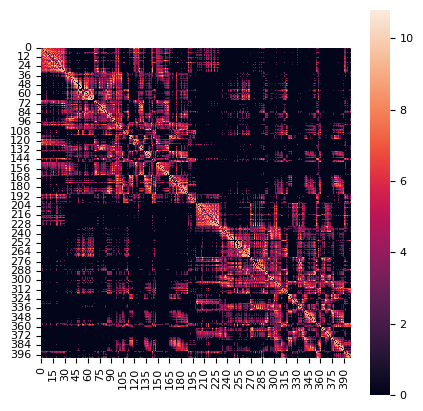

In [4]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(A, ax=ax, square=True)
plt.show()

In [5]:
# load rsfMRI clusters
k = 7
n_states = k
if which_data == 'macaque':
    fmri_clusters_file = '{0}_fmri_clusters_k-{1}.npy'.format(which_data, k)
else:
    fmri_clusters_file = '{0}_{1}_rsts_fmri_clusters_k-{2}.npy'.format(which_data, atlas, k)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])


In [6]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
if which_data == 'macaque':
    parc_centroids = pd.read_csv(os.path.join(indir, 'macaque', 'MarkovCC12_M132_182-area.32k_fs_LR_mean_vertex.csv'), index_col=0)
else:
    parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
    parc_centroids.drop(columns=['ROI Label'], inplace=True)
parc_centroids.head()

,R,A,S
ROI Name,,,
7Networks_LH_Vis_1,-33,-42,-21
7Networks_LH_Vis_2,-30,-33,-18
7Networks_LH_Vis_3,-36,-62,-17
7Networks_LH_Vis_4,-24,-55,-8
7Networks_LH_Vis_5,-23,-73,-10


In [7]:
distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

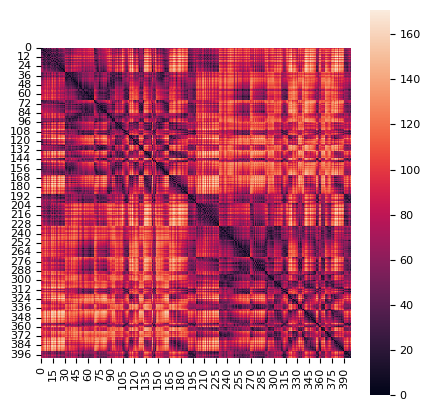

In [8]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(distance_matrix, ax=ax, square=True)
plt.show()

# Permuted A

In [9]:
# run permutation
n_perms = 5000  # number of permutations
n_nodes = A.shape[0]

# containers for null distributions
Wwp = np.zeros((n_nodes, n_nodes, n_perms))
Wsp = np.zeros((n_nodes, n_nodes, n_perms))
Wssp = np.zeros((n_nodes, n_nodes, n_perms))

for perm in tqdm(np.arange(n_perms)):
    # rewire adjacency matrix using geomsurr
    Wwp[:, :, perm], Wsp[:, :, perm], Wssp[:, :, perm] = geomsurr(W=A, D=distance_matrix, seed=perm)

100%|██████████| 5000/5000 [02:16<00:00, 36.75it/s]


In [10]:
file_str = A_file.split('.')[0] + '_perm-wwp-{0}.npy'.format(n_perms)
print(file_str)
np.save(os.path.join(outdir, file_str), Wwp)

file_str = A_file.split('.')[0] + '_perm-wsp-{0}.npy'.format(n_perms)
print(file_str)
np.save(os.path.join(outdir, file_str), Wsp)

file_str = A_file.split('.')[0] + '_perm-wssp-{0}.npy'.format(n_perms)
print(file_str)
np.save(os.path.join(outdir, file_str), Wssp)

HCPYA_Schaefer4007_Am_perm-wwp-5000.npy
HCPYA_Schaefer4007_Am_perm-wsp-5000.npy
HCPYA_Schaefer4007_Am_perm-wssp-5000.npy


# Permuted states

In [11]:
centroids_surrogates = np.zeros((n_states, n_nodes, n_perms))
for state_idx in tqdm(np.arange(n_states)):
    base = Base(x=centroids[state_idx, :], D=distance_matrix)
    surrogates = base(n=n_perms)
    centroids_surrogates[state_idx] = surrogates.T

100%|██████████| 7/7 [39:01<00:00, 334.57s/it]


In [12]:
file_str = fmri_clusters_file.split('.')[0] + '_brainsmash-surrogates-{1}.npy'.format(n_perms, n_perms)
print(file_str)
np.save(os.path.join(outdir, file_str), centroids_surrogates)

HCPYA_Schaefer4007_rsts_fmri_clusters_k-7_brainsmash-surrogates-5000.npy
